In [1]:
import pandas as pd
import numpy as np
import nltk
import textstat
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

# Load and clean dataset
data = pd.read_csv("WelFake_Dataset.csv")
data.dropna(inplace=True)
data['text'] = data['text'].astype(str)

# Display basic info
print("Dataset Info:")
data.info()
print("\nFirst few rows:")
data.head()

[nltk_data] Downloading package punkt to C:\Users\Zul
[nltk_data]     Zaki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Zul
[nltk_data]     Zaki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  71537 non-null  int64 
 1   title       71537 non-null  object
 2   text        71537 non-null  object
 3   label       71537 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB

First few rows:


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [2]:
from tqdm.notebook import tqdm

def get_readability(text):
    try:
        return textstat.flesch_reading_ease(text)
    except Exception:
        return 50

def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

def get_lexical_diversity(text):
    words = text.split()
    if not words:
        return 0
    return len(set(words)) / len(words)

In [3]:
# Cell 3: Apply Feature Engineering
tqdm.pandas()

data['readability'] = data['text'].progress_apply(get_readability)
data['vader_sentiment'] = data['text'].progress_apply(get_vader_sentiment)
data['lexical_diversity'] = data['text'].progress_apply(get_lexical_diversity)

  0%|          | 0/71537 [00:00<?, ?it/s]

  0%|          | 0/71537 [00:00<?, ?it/s]

  0%|          | 0/71537 [00:00<?, ?it/s]

In [4]:
selected_features = ['readability', 'vader_sentiment', 'lexical_diversity']

X = data[['text'] + selected_features]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X['text']

class MetaSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names]

In [6]:
meta_features = Pipeline([
    ('select', MetaSelector(selected_features)),
    ('scale', StandardScaler())
])

rf_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', Pipeline([
            ('get_text', TextSelector()),
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)))
        ])),
        ('meta', meta_features)
    ])),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

from tqdm.notebook import tqdm
with tqdm(total=1, desc="Fitting Random Forest") as pbar:
    rf_pipeline.fit(X_train, y_train)
    pbar.update(1)

Fitting Random Forest:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', Pipeline([
            ('get_text', TextSelector()),
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)))
        ])),
        ('meta', meta_features)
    ])),
    ('clf', DecisionTreeClassifier(random_state=42))
])

with tqdm(total=1, desc="Fitting Decision Tree") as pbar:
    dt_pipeline.fit(X_train, y_train)
    pbar.update(1)

Fitting Decision Tree:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Random Forest Evaluation
y_pred_rf = rf_pipeline.predict(X_test)
print("🔍 Random Forest Model")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Decision Tree Evaluation
y_pred_dt = dt_pipeline.predict(X_test)
print("🔍 Decision Tree Model")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

🔍 Random Forest Model
Accuracy: 0.9517053396701146
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      7081
           1       0.94      0.97      0.95      7227

    accuracy                           0.95     14308
   macro avg       0.95      0.95      0.95     14308
weighted avg       0.95      0.95      0.95     14308

🔍 Decision Tree Model
Accuracy: 0.9218618954431087
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7081
           1       0.91      0.94      0.92      7227

    accuracy                           0.92     14308
   macro avg       0.92      0.92      0.92     14308
weighted avg       0.92      0.92      0.92     14308



In [12]:
import joblib
print(joblib.dump(rf_pipeline, 'rf_model.pkl'))
print(joblib.dump(dt_pipeline, 'dt_model.pkl'))

['rf_model.pkl']
['dt_model.pkl']


<Figure size 640x480 with 0 Axes>

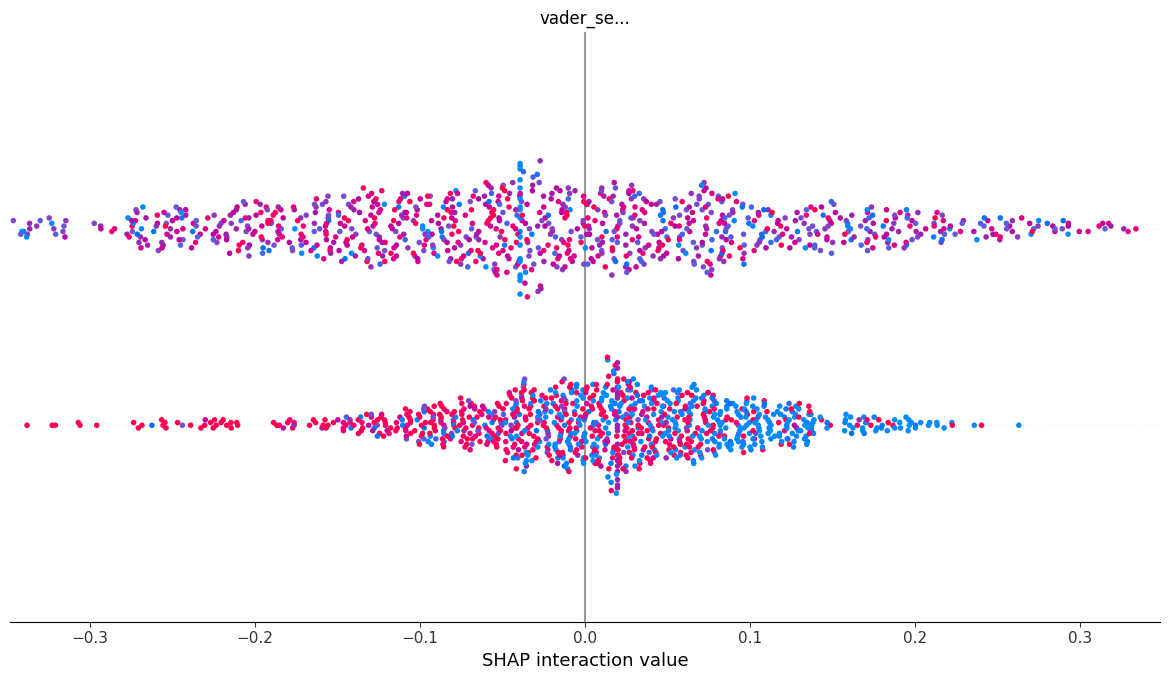

In [13]:
from sklearn.ensemble import RandomForestClassifier
import shap

# Train a model only on meta features
rf_meta = RandomForestClassifier(n_estimators=100, random_state=42)
rf_meta.fit(X_train[selected_features], y_train)

# Sample for SHAP
sample = X_test[selected_features].sample(1000, random_state=42)

# SHAP explanation
explainer = shap.TreeExplainer(rf_meta)
shap_values = explainer(sample)
shap.summary_plot(shap_values, sample, plot_type="bar")

100%|===================| 28606/28616 [35:29<00:00]        

<Figure size 640x480 with 0 Axes>

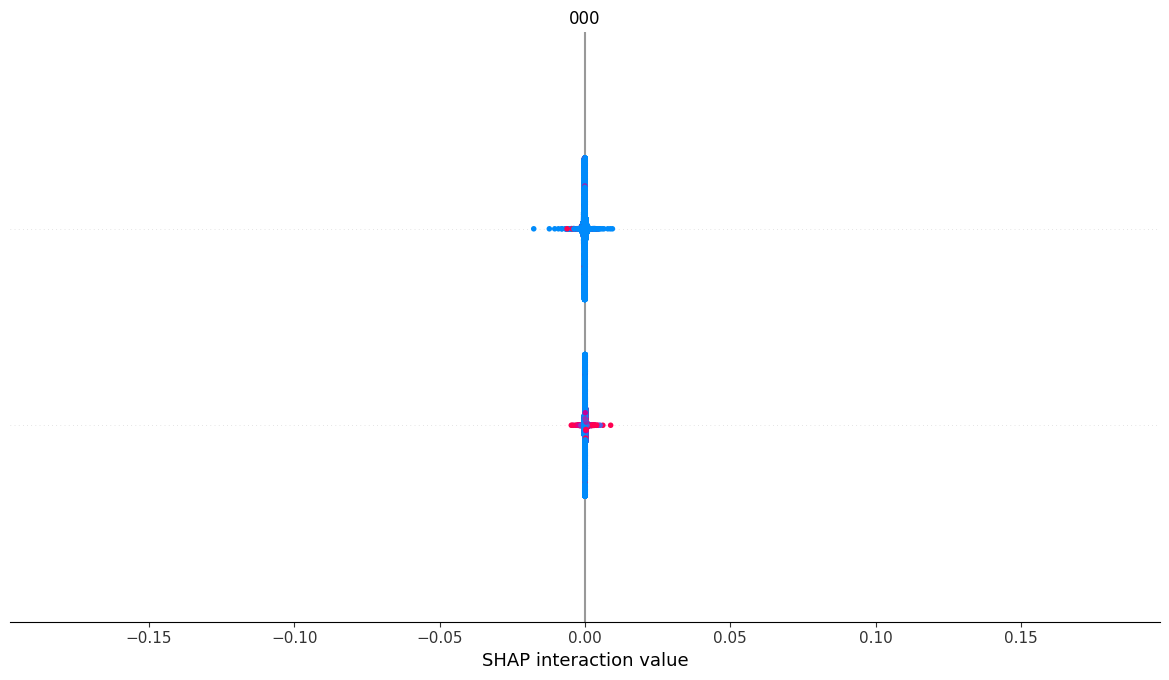

In [20]:
import shap

rf_clf = rf_pipeline.named_steps['clf']
full_X_test = rf_pipeline.named_steps['features'].transform(X_test)

# Convert sparse matrix to dense
full_X_test_dense = full_X_test.toarray()

explainer = shap.Explainer(rf_clf, full_X_test_dense)
shap_values = explainer(full_X_test_dense)

# Get feature names: TF-IDF + meta
meta_names = selected_features
tfidf_names = rf_pipeline.named_steps['features'].transformer_list[0][1].named_steps['tfidf'].get_feature_names_out()
all_feature_names = list(tfidf_names) + meta_names

shap.summary_plot(shap_values, features=full_X_test_dense, feature_names=all_feature_names, plot_type="bar")